##### Copyright 2018 The TensorFlow Authors.

In [2]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Text classification with an RNN

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/text/tutorials/text_classification_rnn"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/text/blob/master/docs/tutorials/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/text/blob/master/docs/tutorials/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/text/docs/tutorials/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This text classification tutorial trains a [recurrent neural network](https://developers.google.com/machine-learning/glossary/#recurrent_neural_network) on the [IMDB large movie review dataset](http://ai.stanford.edu/~amaas/data/sentiment/) for sentiment analysis.

## Setup

In [3]:
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

2022-05-12 00:47:26.721107: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
/home/jovyan/.conda/envs/tf2/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
print('1: ', tf.config.list_physical_devices('GPU'))
print('2: ', tf.test.is_built_with_cuda())
print('3: ', tf.test.gpu_device_name())
print('4: ', tf.config.get_visible_devices())

1:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
2:  True
3:  /device:GPU:0
4:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2022-05-12 00:47:35.565069: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-05-12 00:47:35.567705: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-05-12 00:47:35.631882: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-12 00:47:35.632254: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:1e.0 name: Tesla M60 computeCapability: 5.2
coreClock: 1.1775GHz coreCount: 16 deviceMemorySize: 7.44GiB deviceMemoryBandwidth: 149.31GiB/s
2022-05-12 00:47:35.632279: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-05-12 00:47:35.636670: I tensorflow/stream_executor/platform/default/dso_loa

Import `matplotlib` and create a helper function to plot graphs:

In [5]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

st be at least one NUMA node, so returning NUMA node zero
2022-05-12 00:47:36.357582: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1406] Created TensorFlow device (/device:GPU:0 with 6988 MB memory) -> physical GPU (device: 0, name: Tesla M60, pci bus id: 0000:00:1e.0, compute capability: 5.2)
2022-05-12 00:47:36.357905: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set


## Setup input pipeline


The IMDB large movie review dataset is a *binary classification* dataset—all the reviews have either a *positive* or *negative* sentiment.

Download the dataset using [TFDS](https://www.tensorflow.org/datasets). See the [loading text tutorial](https://www.tensorflow.org/tutorials/load_data/text) for details on how to load this sort of data manually.


In [6]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

2022-05-12 00:47:37.901756: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-12 00:47:37.902025: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:1e.0 name: Tesla M60 computeCapability: 5.2
coreClock: 1.1775GHz coreCount: 16 deviceMemorySize: 7.44GiB deviceMemoryBandwidth: 149.31GiB/s
2022-05-12 00:47:37.902062: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-05-12 00:47:37.902087: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-05-12 00:47:37.902100: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2022-05-12 00:47:37.902112: I tensorflow/stream_executor/platform/de

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

Initially this returns a dataset of (text, label pairs):

In [7]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

2022-05-12 00:47:38.035357: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-05-12 00:47:38.036214: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2300010000 Hz


text:  b'I have no idea what the other reviewer is talking about- this was a wonderful movie, and created a sense of the era that feels like time travel. The characters are truly young, Mary is a strong match for Byron, Claire is juvenile and a tad annoying, Polidori is a convincing beaten-down sycophant... all are beautiful, curious, and decadent... not the frightening wrecks they are in Gothic.<br /><br />Gothic works as an independent piece of shock film, and I loved it for different reasons, but this works like a Merchant and Ivory film, and was from my readings the best capture of what the summer must have felt like. Romantic, yes, but completely rekindles my interest in the lives of Shelley and Byron every time I think about the film. One of my all-time favorites.'
label:  1


Next shuffle the data for training and create batches of these `(text, label)` pairs:

In [8]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [9]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [10]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b'Sure I\'ve seen bad movies in my life, but this one was so bad that I actually became angry in the theater. I wanted my money back. I wrote to the director asking him to refund my movie ticket, of course I didn\'t receive a refund (or even a reply) but it\'s the point that matters. On a scale of 1-10 I give this movie a -42. Why did the "Jeep" (Chevy Blazer??) stop running from being hit with a bat? Why did they hit the "Jeep"(Chevy Blazer?????) with the bat in the first place instead of cracking the bum\'s skull? The plot was thin, the movie filled with obvious clich\xc3\xa9s, and certain parts of it just didn\'t make any sense.'
 b"I don't remember a movie where I have cared less about where the characters have come from, what happens to them or where they are going. I realize that Hollywood's greatest pastime is navel-gazing, but these people are either too despicable or too boring to take up time with. For what it's worth, though, the discussion that followed the showing

## Create the text encoder

The raw text loaded by `tfds` needs to be processed before it can be used in a model. The simplest way to process text for training is using the `TextVectorization` layer. This layer has many capabilities, but this tutorial sticks to the default behavior.

Create the layer, and pass the dataset's text to the layer's `.adapt` method:

In [11]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE)


encoder.adapt(train_dataset.map(lambda text, label: text))

The `.adapt` method sets the layer's vocabulary. Here are the first 20 tokens. After the padding and unknown tokens they're sorted by frequency: 

In [12]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

Once the vocabulary is set, the layer can encode text into indices. The tensors of indices are 0-padded to the longest sequence in the batch (unless you set a fixed `output_sequence_length`):

In [13]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[243, 195, 108, ...,   0,   0,   0],
       [ 10,  90, 364, ...,   0,   0,   0],
       [ 10,  90, 118, ...,   0,   0,   0]])

With the default settings, the process is not completely reversible. There are three main reasons for that:

1. The default value for `preprocessing.TextVectorization`'s `standardize` argument is `"lower_and_strip_punctuation"`.
2. The limited vocabulary size and lack of character-based fallback results in some unknown tokens.

In [14]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'Sure I\'ve seen bad movies in my life, but this one was so bad that I actually became angry in the theater. I wanted my money back. I wrote to the director asking him to refund my movie ticket, of course I didn\'t receive a refund (or even a reply) but it\'s the point that matters. On a scale of 1-10 I give this movie a -42. Why did the "Jeep" (Chevy Blazer??) stop running from being hit with a bat? Why did they hit the "Jeep"(Chevy Blazer?????) with the bat in the first place instead of cracking the bum\'s skull? The plot was thin, the movie filled with obvious clich\xc3\xa9s, and certain parts of it just didn\'t make any sense.'
Round-trip:  sure ive seen bad movies in my life but this one was so bad that i actually became [UNK] in the theater i wanted my money back i [UNK] to the director [UNK] him to [UNK] my movie [UNK] of course i didnt [UNK] a [UNK] or even a [UNK] but its the point that [UNK] on a [UNK] of [UNK] i give this movie a [UNK] why did the [UNK] [UNK] [UN

## Create the model

![A drawing of the information flow in the model](images/bidirectional.png)

Above is a diagram of the model. 

1. This model can be build as a `tf.keras.Sequential`.

2. The first layer is the `encoder`, which converts the text to a sequence of token indices.

3. After the encoder is an embedding layer. An embedding layer stores one vector per word. When called, it converts the sequences of word indices to sequences of vectors. These vectors are trainable. After training (on enough data), words with similar meanings often have similar vectors.

  This index-lookup is much more efficient than the equivalent operation of passing a one-hot encoded vector through a `tf.keras.layers.Dense` layer.

4. A recurrent neural network (RNN) processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input on the next timestep.

  The `tf.keras.layers.Bidirectional` wrapper can also be used with an RNN layer. This propagates the input forward and backwards through the RNN layer and then concatenates the final output. 

  * The main advantage of a bidirectional RNN is that the signal from the beginning of the input doesn't need to be processed all the way through every timestep to affect the output.  

  * The main disadvantage of a bidirectional RNN is that you can't efficiently stream predictions as words are being added to the end.

5. After the RNN has converted the sequence to a single vector the two `layers.Dense` do some final processing, and convert from this vector representation to a single logit as the classification output. 


The code to implement this is below:

In [15]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

Please note that Keras sequential model is used here since all the layers in the model only have single input and produce single output. In case you want to use stateful RNN layer, you might want to build your model with Keras functional API or model subclassing so that you can retrieve and reuse the RNN layer states. Please check [Keras RNN guide](https://www.tensorflow.org/guide/keras/rnn#rnn_state_reuse) for more details.

The embedding layer [uses masking](https://www.tensorflow.org/guide/keras/masking_and_padding) to handle the varying sequence-lengths. All the layers after the `Embedding` support masking:

In [16]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


To confirm that this works as expected, evaluate a sentence twice. First, alone so there's no padding to mask:

In [17]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

2022-05-12 00:48:04.243884: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-05-12 00:48:04.615973: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


[-0.01620666]


Now, evaluate it again in a batch with a longer sentence. The result should be identical:

In [18]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

[-0.01620666]


Compile the Keras model to configure the training process:

In [19]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

## Train the model

In [20]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 56s 121ms/step - loss: 0.6836 - accuracy: 0.5172 - val_loss: 0.6051 - val_accuracy: 0.6724
Epoch 2/10
391/391 [==============================] - 43s 109ms/step - loss: 0.5130 - accuracy: 0.7277 - val_loss: 0.4047 - val_accuracy: 0.8000
Epoch 3/10
391/391 [==============================] - 43s 109ms/step - loss: 0.3906 - accuracy: 0.8169 - val_loss: 0.3405 - val_accuracy: 0.8630
Epoch 4/10
391/391 [==============================] - 43s 109ms/step - loss: 0.3397 - accuracy: 0.8565 - val_loss: 0.3277 - val_accuracy: 0.8510
Epoch 5/10
391/391 [==============================] - 43s 108ms/step - loss: 0.3241 - accuracy: 0.8636 - val_loss: 0.3354 - val_accuracy: 0.8667
Epoch 6/10
391/391 [==============================] - 43s 108ms/step - loss: 0.3183 - accuracy: 0.8669 - val_loss: 0.3042 - val_accuracy: 0.8682
Epoch 7/10
391/391 [==============================] - 43s 109ms/step - loss: 0.3062 - accuracy: 0.8701 - val_loss: 0.2988 - val_ac

In [21]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 18s 45ms/step - loss: 0.3229 - accuracy: 0.8518
Test Loss: 0.32285580039024353
Test Accuracy: 0.8518000245094299


In [ ]:
%load_ext tensorboard

In [26]:
%tensorboard --logdir logs/

(0.0, 0.6759338796138763)

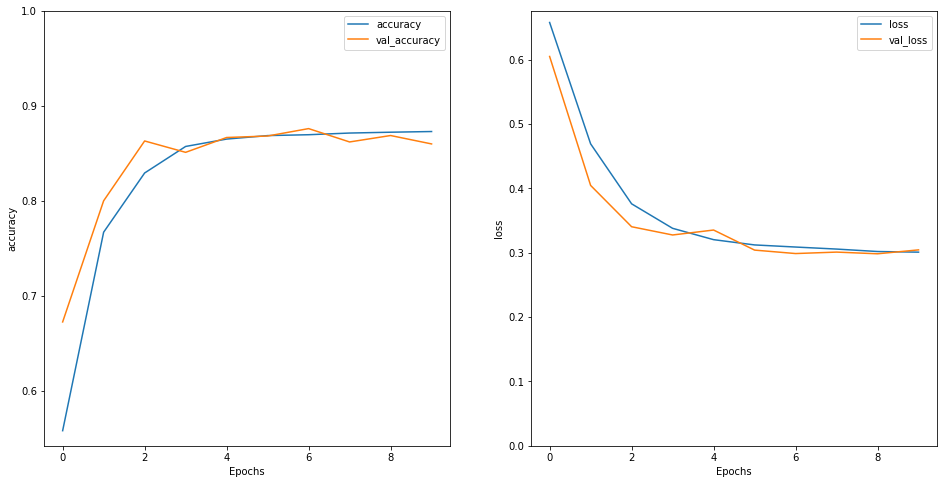

In [27]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

Run a prediction on a new sentence:

If the prediction is >= 0.0, it is positive else it is negative.

In [28]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

In [29]:
predictions

array([[0.87378246]], dtype=float32)